In [1]:
import numpy as np 
#setup camera with a simple camera matrix P 
f = 100 
cx = 200 
cy = 200 
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]]) 
I = np.eye(3) 
t = np.array([[0], [0], [0]]) 
P = np.dot(K, np.hstack((I, t))) 

In [2]:
def project(P, X): #X is an array of 3D points 
    x = np.dot(P, X) 
    for i in range(3): #convert to inhomogeneous coordinates 
        x[i] /= x[2] 
    return x 

In [3]:
#load data 
points_3D = np.loadtxt('house.p3d').T #T means tranpose 
points_3D = np.vstack((points_3D, np.ones(points_3D.shape[1]))) 

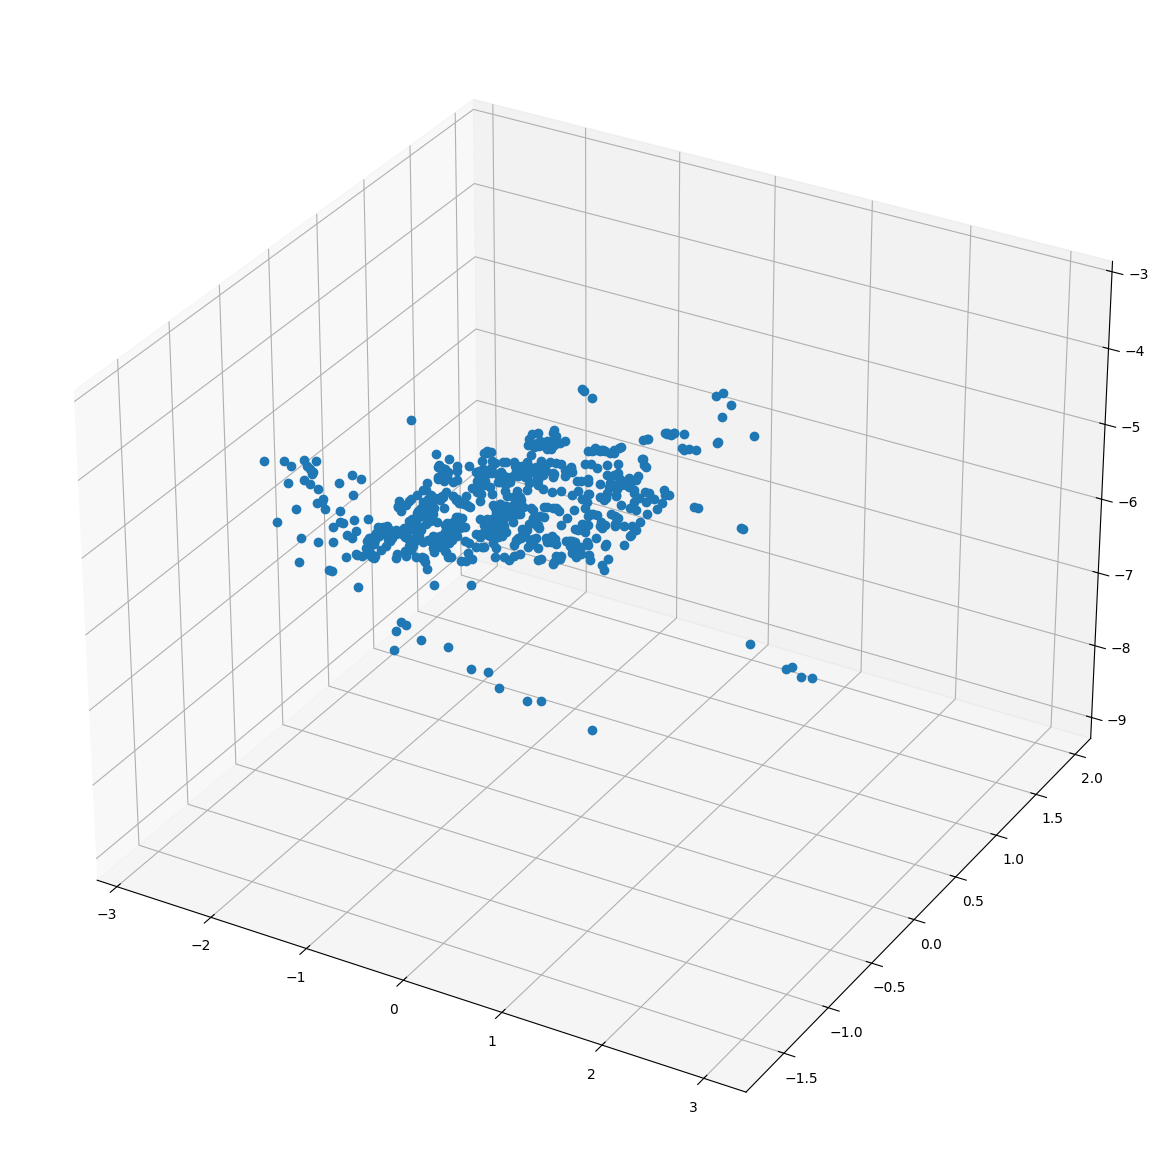

In [4]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d 
 
fig = plt.figure(figsize = [15,15]) 
 
ax = fig.add_subplot(projection = "3d") 
ax.view_init(elev=None, azim=None) #you can set elevation/azimuth with different values 
 
ax.plot(points_3D[0], points_3D[1], points_3D[2], 'o') 
 
plt.draw() 
plt.show() 

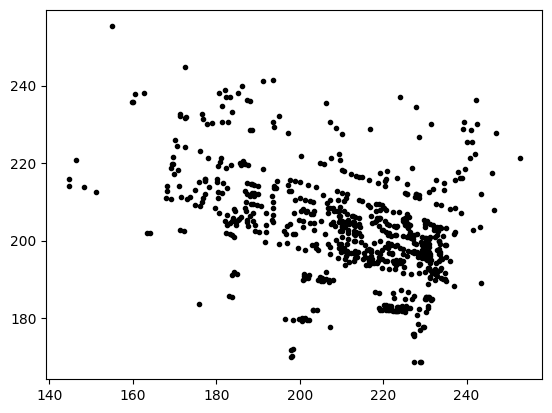

In [5]:
#projection 
points_2D = project(P, points_3D) 
 
#plot projection 
from matplotlib import pyplot as plt 
plt.plot(points_2D[0], points_2D[1], 'k.') 
plt.show() 

In [6]:
print(points_2D.shape) 
print(points_3D.shape)

(3, 672)
(4, 672)


In [7]:
n_points = 6 
points_3D_sampled = points_3D[:,:n_points] 
points_2D_sampled = points_2D[:,:n_points] 

In [8]:
A = np.zeros((2*n_points, 12), np.float32) 
for i in range(n_points): 
    A[2*i,:4] = points_3D_sampled[:,i].T 
    A[2*i,8:12] = -points_2D_sampled[0,i] * points_3D_sampled[:,i].T 
    A[2*i+1,4:8] = points_3D_sampled[:,i].T 
    A[2*i+1,8:12] = -points_2D_sampled[1,i] * points_3D_sampled[:,i].T 

In [9]:
from scipy import linalg 
p = linalg.solve(A, np.zeros((12, 1), np.float32)) 
print(p)

[[-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]]


C:\Users\micha\AppData\Local\Temp\ipykernel_16512\476451600.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=3.3444e-12): result may not be accurate.
  p = linalg.solve(A, np.zeros((12, 1), np.float32))


In [10]:
U, S, V = linalg.svd(A)

In [11]:
minS = np.min(S) 
conditon = (S == minS) 
minID = np.where(conditon) 
print('index of the smallest singular value is: ', minID[0]) 

index of the smallest singular value is:  [11]


In [12]:
P_hat = V[minID[0],:].reshape(3, 4) / minS 

print(P) 
print(P_hat) 

[[100.   0. 200.   0.]
 [  0. 100. 200.   0.]
 [  0.   0.   1.   0.]]
[[ 9.7131828e+04 -3.9299371e+02  1.9404066e+05 -3.5585123e+02]
 [ 5.3738548e+01  9.6735898e+04  1.9402431e+05 -4.7194104e+02]
 [ 1.6094728e-01 -1.7373450e+00  9.7033148e+02 -1.3359228e+00]]


In [13]:
x_P_hat = project(P_hat, points_3D_sampled[:, 0]) 
print(x_P_hat) 

[225.25296769 181.44311637   1.        ]


In [14]:
x_P = points_2D_sampled[:,0] 
print(x_P)

[225.25322768 181.44331296   1.        ]


In [15]:
x_P = points_2D 
x_P_hat = project(P_hat, points_3D) 
dist = 0 
for i in range(x_P.shape[1]): 
    dist += np.linalg.norm(x_P[:,i] - x_P_hat[:,i]) 
dist /= x_P.shape[1] 
print(dist) 

0.011773759478216198


In [16]:
n_points_ratio = np.arange(0.1, 1.1, 0.1)

x_P = points_2D 

dists = []

for ratio in n_points_ratio:
    n_points = int(points_3D.shape[1] * ratio)
    points_3D_sampled = points_3D[:,:n_points] 
    points_2D_sampled = points_2D[:,:n_points] 

    A = np.zeros((2*n_points, 12), np.float32) 
    for i in range(n_points): 
        A[2*i,:4] = points_3D_sampled[:,i].T 
        A[2*i,8:12] = -points_2D_sampled[0,i] * points_3D_sampled[:,i].T 
        A[2*i+1,4:8] = points_3D_sampled[:,i].T 
        A[2*i+1,8:12] = -points_2D_sampled[1,i] * points_3D_sampled[:,i].T 

    U, S, V = linalg.svd(A)

    minS = np.min(S) 
    conditon = (S == minS) 
    minID = np.where(conditon) 

    P_hat = V[minID[0],:].reshape(3, 4) / minS 

    x_P_hat = project(P_hat, points_3D) 
    dist = 0 
    for i in range(x_P.shape[1]): 
        dist += np.linalg.norm(x_P[:,i] - x_P_hat[:,i]) 
    dist /= x_P.shape[1] 

    dists.append(dist)

for i in range(len(n_points_ratio)):
    print(f"Distance when n_points is {int(n_points_ratio[i]*100)}% = {dists[i]}")

print(f"Best value on n_points is achieve at {int(n_points_ratio[np.argmin(dists)]*100)}% with distance of {np.min(dists)}")

Distance when n_points is 10% = 0.002172216947203982
Distance when n_points is 20% = 0.0012794707110595303
Distance when n_points is 30% = 0.0009088265493038076
Distance when n_points is 40% = 0.0008041744981853316
Distance when n_points is 50% = 0.002751307119252027
Distance when n_points is 60% = 0.004232963239247349
Distance when n_points is 70% = 0.0016789367503653636
Distance when n_points is 80% = 0.0016325768013172159
Distance when n_points is 90% = 0.004240840034817397
Distance when n_points is 100% = 0.0024754008867211544
Best value on n_points is achieve at 40% with distance of 0.0008041744981853316


In [17]:
import homography 
import sfm 
import ransac 

Number of detected keypoints in img1: 971
Number of detected keypoints in img2: 983


(-0.5, 959.5, 639.5, -0.5)

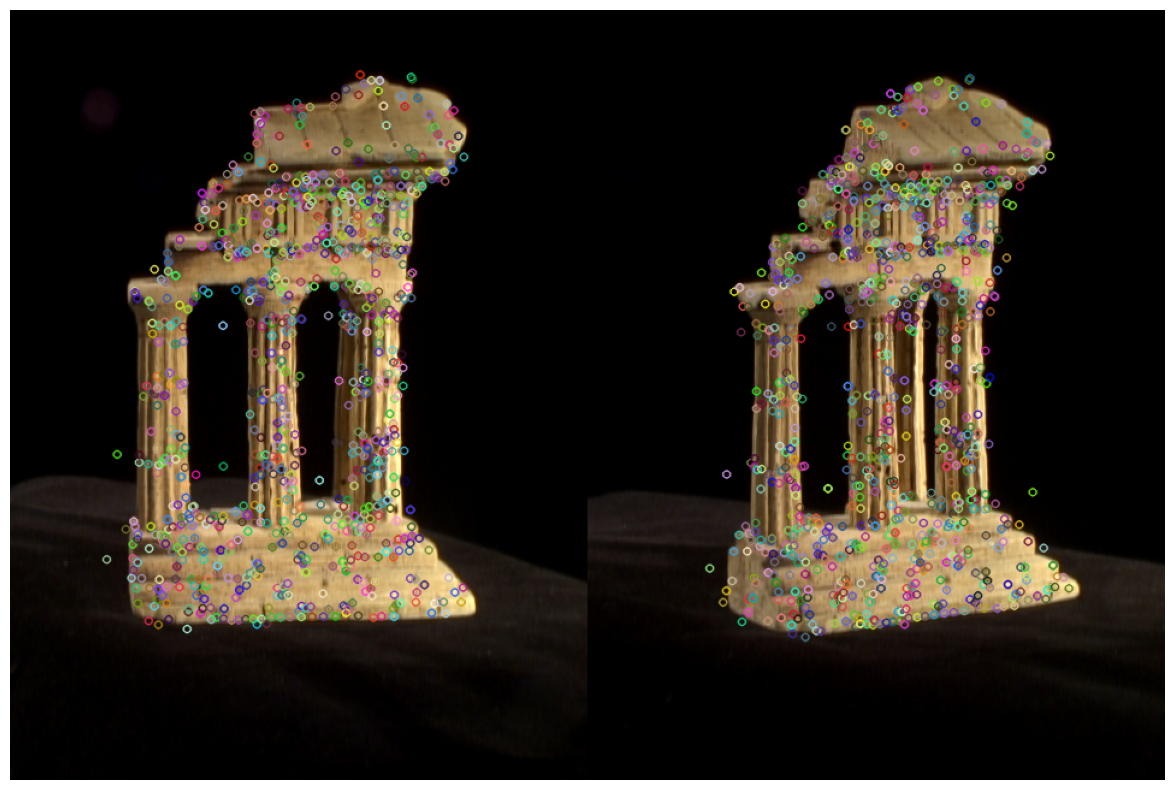

In [19]:
import cv2 as cv 
sift = cv.SIFT_create() 
img1 = cv.imread('temple2A.png') 
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) 
kp1, des1 = sift.detectAndCompute(img1_gray, None) 
img2 = cv.imread('temple2B.png') 
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY) 
kp2, des2 = sift.detectAndCompute(img2_gray, None) 
img1_kp = img1.copy() 
img1_kp = cv.drawKeypoints(img1, kp1, img1_kp) 
 
print("Number of detected keypoints in img1: %d" % (len(kp1))) 
 
img2_kp = img2.copy() 
img2_kp = cv.drawKeypoints(img2, kp2, img2_kp) 
 
print("Number of detected keypoints in img2: %d" % (len(kp2))) 
 
img1_2_kp = np.hstack((img1_kp, img2_kp)) 
 
plt.figure(figsize = (20, 10)) 
plt.imshow(img1_2_kp[:,:,::-1]) 
plt.axis('off') 

In [20]:

bf = cv.BFMatcher(crossCheck = True) #crossCheck=True: find consistent matches 
matches = bf.match(des1, des2) 
matches = sorted(matches, key = lambda x:x.distance) 
print("Number of consistent matches: %d" % len(matches)) 

Number of consistent matches: 483


(-0.5, 959.5, 639.5, -0.5)

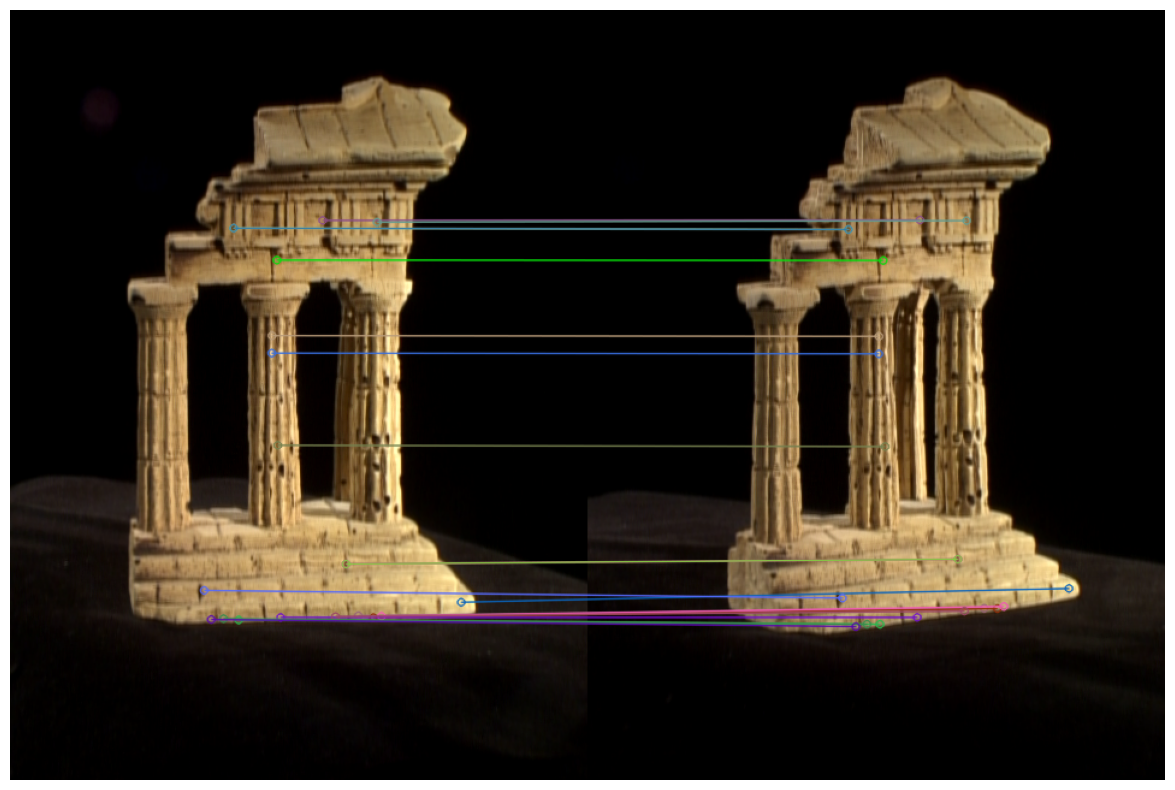

In [22]:
img1_2_matches = cv.drawMatches(img1, kp1, img2, kp2,  
                              matches[:20],  
                              None,  
                              flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) 
 
plt.figure(figsize = (20, 10)) 
plt.imshow(img1_2_matches[:,:,::-1]) 
plt.axis('off') 

In [23]:
n_matches = min(len(matches), 1000) 
 
kp1_array = np.zeros((2, n_matches), np.float32) 
for i in range(n_matches): 
    kp1_array[0][i] = kp1[matches[i].queryIdx].pt[0] 
    kp1_array[1][i] = kp1[matches[i].queryIdx].pt[1] 
     
kp2_array = np.zeros((2, n_matches), np.float32) 
for i in range(n_matches): 
    kp2_array[0][i] = kp2[matches[i].trainIdx].pt[0] 
    kp2_array[1][i] = kp2[matches[i].trainIdx].pt[1] 

In [24]:
x1 = homography.make_homog(kp1_array) 
x2 = homography.make_homog(kp2_array)

In [25]:
K = np.array([[2394,0,932], [0,2398,628], [0,0,1]]) 
P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]]) 

In [27]:
x1n = np.dot(linalg.inv(K), x1) 
x2n = np.dot(linalg.inv(K), x2) 

In [28]:
#estimate E with RANSAC 
model = sfm.RansacModel() 
E, inliers = sfm.F_from_ransac(x1n, x2n, model) 

In [29]:
#compute camera matrices (P2 will be list of four solutions) 
P2_all = sfm.compute_P_from_essential(E) 
 
#pick the solution with points in front of cameras 
ind = 0 
maxres = 0 
for i in range(4): 
    #triangulate inliers and compute depth for each camera 
    X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2_all[i]) 
    d1 = np.dot(P1, X)[2] 
    d2 = np.dot(P2_all[i], X)[2] 
    s = sum(d1 > 0) + sum(d2 > 0) 
    if s > maxres: 
        maxres = s 
        ind = i 
        infront = (d1 > 0) & (d2 > 0) 
P2 = P2_all[ind]

In [30]:
#triangulate inliers and remove points not in front of both cameras 
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2) 
X = X[:, infront]

In [31]:
print(len(X[0]))

350


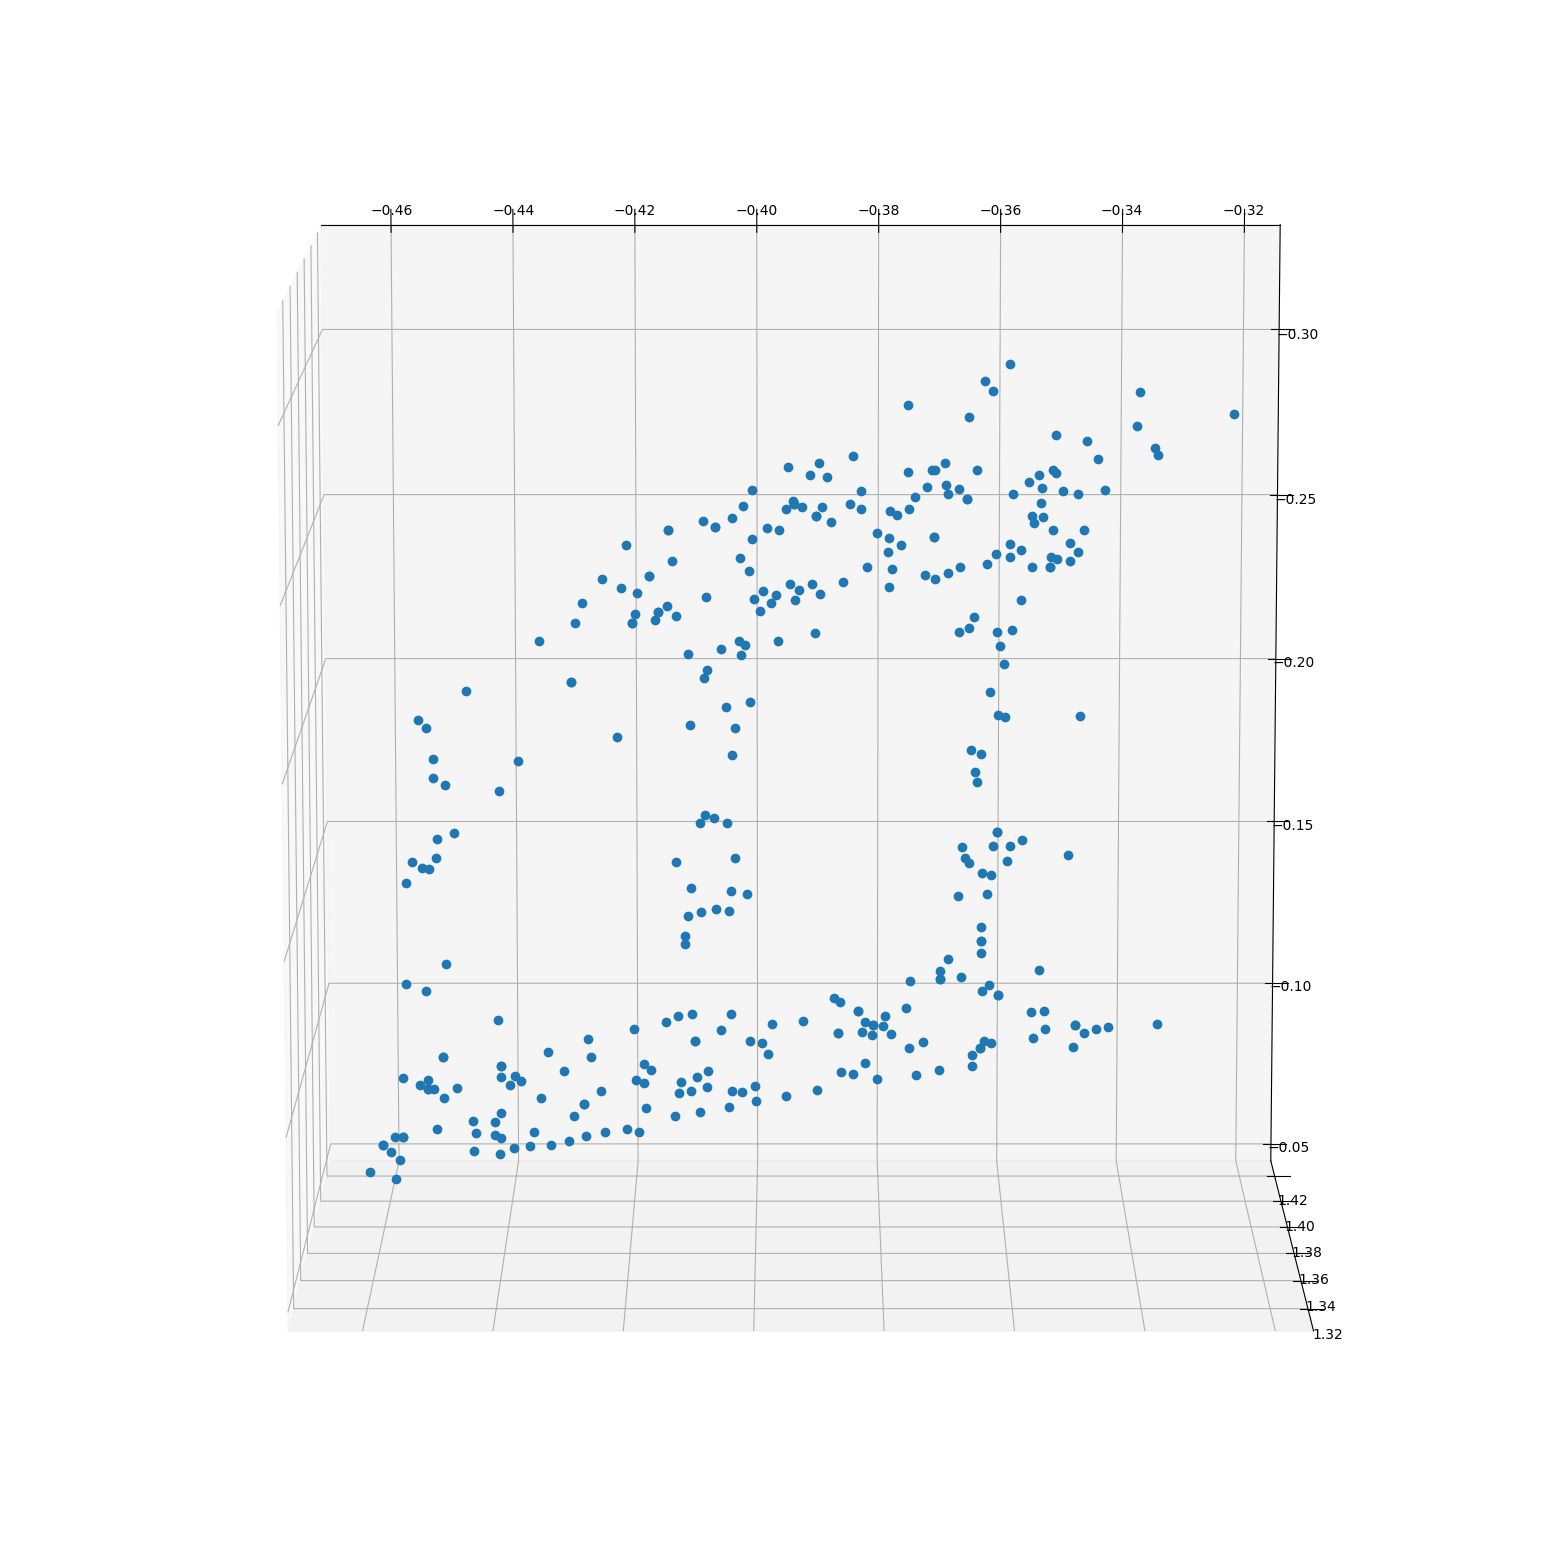

In [33]:
#3D plot 
fig = plt.figure(figsize = [20,20]) 
 
ax = fig.add_subplot(projection = "3d") 
ax.view_init(elev = -80, azim= -90) 
 
ax.plot(X[0], X[1], X[2], 'o') 
 
plt.draw() 
plt.show()

In [36]:
kp2_projected_array = project(P2, X)
kp2_projected_array = np.dot(K, kp2_projected_array)

(-0.5, 479.5, 639.5, -0.5)

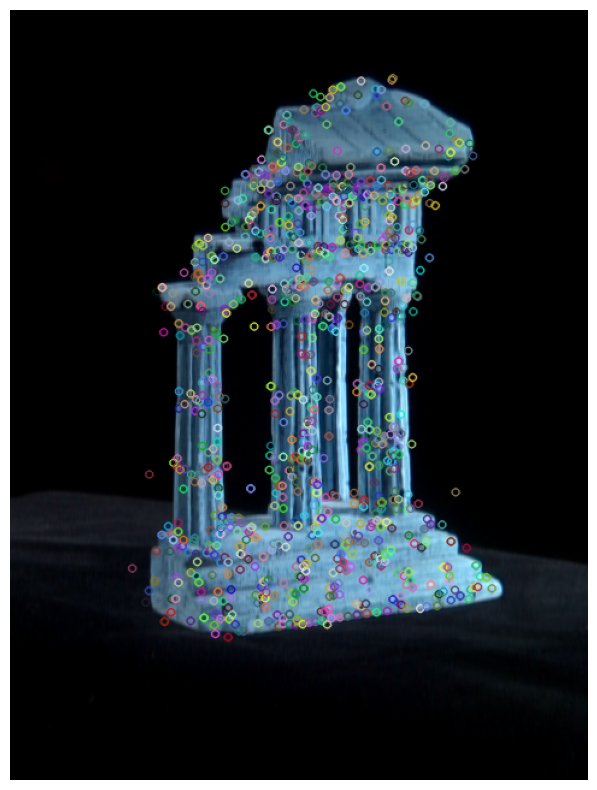

In [38]:
img2_kp = img2.copy() 
img2_kp = cv.drawKeypoints(img2, kp2, img2_kp) 
 
plt.figure(figsize = (20, 10)) 
plt.imshow(img2_kp) 
plt.axis('off') 